# Bipedal_Walker
## Deep Deterministic Policy Gradient (DDPG) TD3 variant
https://pylessons.com/BipedalWalker-v3-PPO

In [2]:
# import standard libraries
import os
import base64
import random
import time
from collections import deque

# import third-party libraries
import gymnasium as gym
import numpy as np
import pandas as pd

import imageio
import IPython
from IPython.display import clear_output
from IPython import display
import PIL.Image
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam

In [3]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce GTX 1070 (UUID: GPU-19cef1c2-e216-e824-c98e-660394f8a4bb)


In [4]:
print(tf.config.list_logical_devices())
print(tf.config.list_physical_devices())

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## create img dir

In [5]:
try: 
    os.mkdir('img') 
except OSError as error:
    print('directory "img" was not created') 

directory "img" was not created


In [13]:
try: 
    os.mkdir('data') 
except OSError as error:
    print('directory "data" was not created') 

## Constants

In [6]:
MINIBATCH_SIZE = 64   # mini-batch size
TAU = 0.005           # soft update parameter

# Hyperparameters
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.99              # discount factor
ALPHA = 1e-4              # learning rate
NUM_STEPS_FOR_UPDATE = 2  # perform a learning update every C time steps

HIDDEN_LAYER_SIZE = 64 #512 # 64

## Load the Environment

In [6]:
env = gym.make('BipedalWalker-v3', render_mode="rgb_array")

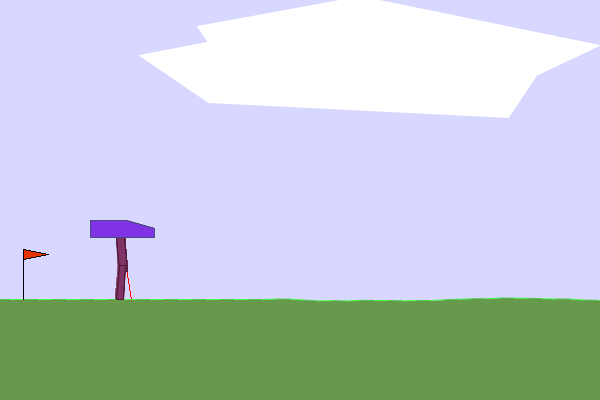

In [7]:
env.reset()
PIL.Image.fromarray(env.render())

In [8]:
state_size = env.observation_space.shape
num_actions = env.action_space.shape[0]

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (24,)
Number of actions: 4


In [9]:
# Reset the environment and get the initial state.
initial_state, info = env.reset()

In [10]:
initial_state

array([ 2.7472950e-03, -2.5396253e-05,  1.9755715e-03, -1.5999831e-02,
        9.1801435e-02, -2.6070834e-03,  8.6036032e-01,  3.3290435e-03,
        1.0000000e+00,  3.2206465e-02, -2.6069032e-03,  8.5391033e-01,
        1.8438009e-03,  1.0000000e+00,  4.4081402e-01,  4.4582012e-01,
        4.6142277e-01,  4.8955020e-01,  5.3410280e-01,  6.0246104e-01,
        7.0914888e-01,  8.8593185e-01,  1.0000000e+00,  1.0000000e+00],
      dtype=float32)

|Num|Name|Min|Max|
|---|---|---|---|
|0|Hip_1 (Torque / Velocity)|-1|+1|
|1|Knee_1 (Torque / Velocity)|-1|+1|
|2|Hip_2 (Torque / Velocity)|-1|+1|
|3|Knee_2 (Torque / Velocity)|-1|+1|

-----

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # -1:cpu, 0:first gpu
import random
import gymnasium as gym
import pylab
import numpy as np
import tensorflow as tf
from tensorboardX import SummaryWriter
#tf.config.experimental_run_functions_eagerly(True) # used for debuging and development
tf.compat.v1.disable_eager_execution() # usually using this for fastest performance
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers.legacy import Adam
import copy

from threading import Thread, Lock
from multiprocessing import Process, Pipe
import time

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    print(f'GPUs {gpus}')
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError: pass

In [3]:
class Environment(Process):
    def __init__(self, env_idx, child_conn, env_name, state_size, action_size, visualize=False):
        super(Environment, self).__init__()
        self.env = gym.make(env_name, render_mode="rgb_array")
        self.is_render = visualize
        self.env_idx = env_idx
        self.child_conn = child_conn
        self.state_size = state_size
        self.action_size = action_size

    def run(self):
        super(Environment, self).run()
        state, _ = self.env.reset()
        state = np.reshape(state, [1, self.state_size])
        self.child_conn.send(state)

        while True:
            action = self.child_conn.recv()
            #if self.is_render and self.env_idx == 0:
                #self.env.render()

            # Take action A and receive the next state S' and reward R
            state, reward, terminated, truncated, info = self.env.step(action)
            done = terminated or truncated
            state = np.reshape(state, [1, self.state_size])

            if done:
                state, _ = self.env.reset()
                state = np.reshape(state, [1, self.state_size])

            self.child_conn.send([state, reward, done, info])

In [4]:
class Actor_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        self.action_space = action_space
        
        X = Dense(512, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X_input)
        X = Dense(256, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        X = Dense(64, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X)
        output = Dense(self.action_space, activation="tanh")(X)

        self.Actor = Model(inputs = X_input, outputs = output)
        self.Actor.compile(loss=self.ppo_loss_continuous, optimizer=optimizer(learning_rate=lr))
        #print(self.Actor.summary())

    def ppo_loss_continuous(self, y_true, y_pred):
        advantages, actions, logp_old_ph, = y_true[:, :1], y_true[:, 1:1+self.action_space], y_true[:, 1+self.action_space]
        LOSS_CLIPPING = 0.2
        logp = self.gaussian_likelihood(actions, y_pred)

        ratio = tf.math.exp(logp - logp_old_ph)

        p1 = ratio * advantages
        p2 = tf.where(advantages > 0, (1.0 + LOSS_CLIPPING)*advantages, (1.0 - LOSS_CLIPPING)*advantages) # minimum advantage

        actor_loss = -tf.math.reduce_mean(tf.math.minimum(p1, p2))

        return actor_loss

    def gaussian_likelihood(self, actions, pred): # for keras custom loss
        log_std = -0.5 * np.ones(self.action_space, dtype=np.float32)
        pre_sum = -0.5 * (((actions-pred)/(tf.math.exp(log_std)+1e-8))**2 + 2*log_std + tf.math.log(2*np.pi))
        return tf.math.reduce_sum(pre_sum, axis=1)

    def predict(self, state):
        return self.Actor.predict(state)

In [5]:
class Critic_Model:
    def __init__(self, input_shape, action_space, lr, optimizer):
        X_input = Input(input_shape)
        old_values = Input(shape=(1,))

        V = Dense(512, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(X_input)
        V = Dense(256, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(V)
        V = Dense(64, activation="relu", kernel_initializer=tf.random_normal_initializer(stddev=0.01))(V)
        value = Dense(1, activation=None)(V)

        self.Critic = Model(inputs=[X_input, old_values], outputs = value)
        self.Critic.compile(loss=[self.critic_PPO2_loss(old_values)], optimizer=optimizer(learning_rate=lr))

    def critic_PPO2_loss(self, values):
        def loss(y_true, y_pred):
            LOSS_CLIPPING = 0.2
            clipped_value_loss = values + tf.clip_by_value(y_pred - values, -LOSS_CLIPPING, LOSS_CLIPPING)
            v_loss1 = (y_true - clipped_value_loss) ** 2
            v_loss2 = (y_true - y_pred) ** 2
            
            value_loss = 0.5 * tf.math.reduce_mean(tf.math.maximum(v_loss1, v_loss2))
            #value_loss = tf.math.reduce_mean((y_true - y_pred) ** 2) # standard PPO loss
            return value_loss
        return loss

    def predict(self, state):
        return self.Critic.predict([state, np.zeros((state.shape[0], 1))])

In [6]:
class PPOAgent:
    # PPO Main Optimization Algorithm
    def __init__(self, env_name, model_name=""):
        # Initialization
        # Environment and PPO parameters
        self.env_name = env_name       
        self.env = gym.make(env_name, render_mode="rgb_array")
        self.action_size = self.env.action_space.shape[0]
        self.state_size = self.env.observation_space.shape
        self.EPISODES = 1000 # total episodes to train through all environments
        self.episode = 0 # used to track the episodes total count of episodes played through all thread environments
        self.max_average = 0 # when average score is above 0 model will be saved
        self.lr = 0.00025
        self.epochs = 10 # training epochs
        self.shuffle = True
        self.Training_batch = 512
        self.optimizer = Adam

        self.replay_count = 0
        self.writer = SummaryWriter(comment="_"+self.env_name+"_"+self.optimizer.__name__+"_"+str(self.lr))
        
        # Instantiate plot memory
        self.scores_, self.episodes_, self.average_ = [], [], [] # used in matplotlib plots

        # Create Actor-Critic network models
        self.Actor = Actor_Model(input_shape=self.state_size, action_space = self.action_size, lr=self.lr, optimizer = self.optimizer)
        self.Critic = Critic_Model(input_shape=self.state_size, action_space = self.action_size, lr=self.lr, optimizer = self.optimizer)
        
        self.Actor_name = f"{self.env_name}_PPO_Actor.h5"
        self.Critic_name = f"{self.env_name}_PPO_Critic.h5"
        #self.load() # uncomment to continue training from old weights

        self.log_std = -0.5 * np.ones(self.action_size, dtype=np.float32)
        self.std = np.exp(self.log_std)

    def act(self, state):
        # Use the network to predict the next action to take, using the model
        pred = self.Actor.predict(state)

        low, high = -1.0, 1.0 # -1 and 1 are boundaries of tanh
        action = pred + np.random.uniform(low, high, size=pred.shape) * self.std
        action = np.clip(action, low, high)
        
        logp_t = self.gaussian_likelihood(action, pred, self.log_std)

        return action, logp_t

    def gaussian_likelihood(self, action, pred, log_std):
        # https://github.com/hill-a/stable-baselines/blob/master/stable_baselines/sac/policies.py
        pre_sum = -0.5 * (((action-pred)/(np.exp(log_std)+1e-8))**2 + 2*log_std + np.log(2*np.pi)) 
        return np.sum(pre_sum, axis=1)

    def discount_rewards(self, reward):
        # Compute the gamma-discounted rewards over an episode
        # We apply the discount and normalize it to avoid big variability of rewards
        gamma = 0.99 # discount rate
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            running_add = running_add * gamma + reward[i]
            discounted_r[i] = running_add

        discounted_r -= np.mean(discounted_r) # normalizing the result
        discounted_r /= (np.std(discounted_r) + 1e-8) # divide by standard deviation
        return discounted_r

    def get_gaes(self, rewards, dones, values, next_values, gamma = 0.99, lamda = 0.90, normalize=True):
        deltas = [r + gamma * (1 - d) * nv - v for r, d, nv, v in zip(rewards, dones, next_values, values)]
        deltas = np.stack(deltas)
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(deltas) - 1)):
            gaes[t] = gaes[t] + (1 - dones[t]) * gamma * lamda * gaes[t + 1]

        target = gaes + values
        if normalize:
            gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)
        return np.vstack(gaes), np.vstack(target)

    def replay(self, states, actions, rewards, dones, next_states, logp_ts):
        # reshape memory to appropriate shape for training
        states = np.vstack(states)
        next_states = np.vstack(next_states)
        actions = np.vstack(actions)
        logp_ts = np.vstack(logp_ts)

        # Get Critic network predictions 
        values = self.Critic.predict(states)
        next_values = self.Critic.predict(next_states)

        # Compute discounted rewards and advantages
        #discounted_r = self.discount_rewards(rewards)
        #advantages = np.vstack(discounted_r - values)
        advantages, target = self.get_gaes(rewards, dones, np.squeeze(values), np.squeeze(next_values))
        '''
        pylab.plot(adv,'.')
        pylab.plot(target,'-')
        ax=pylab.gca()
        ax.grid(True)
        pylab.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.06)
        pylab.show()
        if str(episode)[-2:] == "00": pylab.savefig(self.env_name+"_"+self.episode+".png")
        '''
        # stack everything to numpy array
        # pack all advantages, predictions and actions to y_true and when they are received
        # in custom loss function we unpack it
        y_true = np.hstack([advantages, actions, logp_ts])
        
        # training Actor and Critic networks
        a_loss = self.Actor.Actor.fit(states, y_true, epochs=self.epochs, verbose=0, shuffle=self.shuffle)
        c_loss = self.Critic.Critic.fit([states, values], target, epochs=self.epochs, verbose=0, shuffle=self.shuffle)

        # calculate loss parameters (should be done in loss, but couldn't find working way how to do that with disabled eager execution)
        pred = self.Actor.predict(states)
        log_std = -0.5 * np.ones(self.action_size, dtype=np.float32)
        logp = self.gaussian_likelihood(actions, pred, log_std)
        approx_kl = np.mean(logp_ts - logp)
        approx_ent = np.mean(-logp)

        self.writer.add_scalar('Data/actor_loss_per_replay', np.sum(a_loss.history['loss']), self.replay_count)
        self.writer.add_scalar('Data/critic_loss_per_replay', np.sum(c_loss.history['loss']), self.replay_count)
        self.writer.add_scalar('Data/approx_kl_per_replay', approx_kl, self.replay_count)
        self.writer.add_scalar('Data/approx_ent_per_replay', approx_ent, self.replay_count)
        self.replay_count += 1
 
    def load(self):
        self.Actor.Actor.load_weights(f"./data/{self.Actor_name}")
        self.Critic.Critic.load_weights(f"./data/{self.Critic_name}")

    def save(self):
        self.Actor.Actor.save_weights(f"./data/{self.Actor_name}")
        self.Critic.Critic.save_weights(f"./data/{self.Critic_name}")
        
    pylab.figure(figsize=(18, 9))
    pylab.subplots_adjust(left=0.05, right=0.98, top=0.96, bottom=0.06)
    def PlotModel(self, score, episode, save=True):
        self.scores_.append(score)
        self.episodes_.append(episode)
        self.average_.append(sum(self.scores_[-50:]) / len(self.scores_[-50:]))
        if str(episode)[-2:] == "00":# much faster than episode % 100
            pylab.plot(self.episodes_, self.scores_, 'b')
            pylab.plot(self.episodes_, self.average_, 'r')
            pylab.ylabel('Score', fontsize=18)
            pylab.xlabel('Steps', fontsize=18)
            try:
                pylab.grid(True)
                pylab.savefig(self.env_name+".png")
            except OSError:
                pass
        # saving best models
        if self.average_[-1] >= self.max_average and save:
            self.max_average = self.average_[-1]
            self.save()
            SAVING = "SAVING"
            # decreaate learning rate every saved model
            #self.lr *= 0.99
            #K.set_value(self.Actor.Actor.optimizer.learning_rate, self.lr)
            #K.set_value(self.Critic.Critic.optimizer.learning_rate, self.lr)
        else:
            SAVING = ""

        return self.average_[-1], SAVING
    
    def run_batch(self):
        state, _ = self.env.reset()
        state = np.reshape(state, [1, self.state_size[0]])
        done, score, SAVING = False, 0, ''
        while True:
            # Instantiate or reset games memory
            states, next_states, actions, rewards, dones, logp_ts = [], [], [], [], [], []
            for t in range(self.Training_batch):
                self.env.render()
                # Actor picks an action
                action, logp_t = self.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, terminated, truncated, info = self.env.step(action[0])
                done = terminated or truncated
                # Memorize (state, next_states, action, reward, done, logp_ts) for training
                states.append(state)
                next_states.append(np.reshape(next_state, [1, self.state_size[0]]))
                actions.append(action)
                rewards.append(reward)
                dones.append(done)
                logp_ts.append(logp_t[0])
                # Update current state shape
                state = np.reshape(next_state, [1, self.state_size[0]])
                score += reward
                if done:
                    self.episode += 1
                    average, SAVING = self.PlotModel(score, self.episode)
                    print(f"\rEpisode: {self.episode}/{self.EPISODES}, score: {score}, average: {average:.2f} {SAVING}", end=" ")
                    self.writer.add_scalar(f'Workers:{1}/score_per_episode', score, self.episode)
                    self.writer.add_scalar(f'Workers:{1}/learning_rate', self.lr, self.episode)
                    self.writer.add_scalar(f'Workers:{1}/average_score',  average, self.episode)
                    
                    state_, done, score, SAVING = self.env.reset(), False, 0, ''
                    state, _ = state_
                    state = np.reshape(state, [1, self.state_size[0]])

            self.replay(states, actions, rewards, dones, next_states, logp_ts)
            if self.episode >= self.EPISODES:
                break

        self.env.close()


    def run_multiprocesses(self, num_worker = 4):
        works, parent_conns, child_conns = [], [], []
        for idx in range(num_worker):
            parent_conn, child_conn = Pipe()
            work = Environment(idx, child_conn, self.env_name, self.state_size[0], self.action_size, True)
            work.start()
            works.append(work)
            parent_conns.append(parent_conn)
            child_conns.append(child_conn)

        states =        [[] for _ in range(num_worker)]
        next_states =   [[] for _ in range(num_worker)]
        actions =       [[] for _ in range(num_worker)]
        rewards =       [[] for _ in range(num_worker)]
        dones =         [[] for _ in range(num_worker)]
        logp_ts =       [[] for _ in range(num_worker)]
        score =         [0 for _ in range(num_worker)]

        state = [0 for _ in range(num_worker)]
        for worker_id, parent_conn in enumerate(parent_conns):
            state[worker_id] = parent_conn.recv()

        while self.episode < self.EPISODES:
            # get batch of action's and log_pi's
            action, logp_pi = self.act(np.reshape(state, [num_worker, self.state_size[0]]))
            
            for worker_id, parent_conn in enumerate(parent_conns):
                parent_conn.send(action[worker_id])
                actions[worker_id].append(action[worker_id])
                logp_ts[worker_id].append(logp_pi[worker_id])

            for worker_id, parent_conn in enumerate(parent_conns):
                next_state, reward, done, _ = parent_conn.recv()

                states[worker_id].append(state[worker_id])
                next_states[worker_id].append(next_state)
                rewards[worker_id].append(reward)
                dones[worker_id].append(done)
                state[worker_id] = next_state
                score[worker_id] += reward

                if done:
                    average, SAVING = self.PlotModel(score[worker_id], self.episode)
                    print("episode: {}/{}, worker: {}, score: {}, average: {:.2f} {}".format(self.episode, self.EPISODES, worker_id, score[worker_id], average, SAVING))
                    self.writer.add_scalar(f'Workers:{num_worker}/score_per_episode', score[worker_id], self.episode)
                    self.writer.add_scalar(f'Workers:{num_worker}/learning_rate', self.lr, self.episode)
                    self.writer.add_scalar(f'Workers:{num_worker}/average_score',  average, self.episode)
                    score[worker_id] = 0
                    if(self.episode < self.EPISODES):
                        self.episode += 1
                        
                        
            for worker_id in range(num_worker):
                if len(states[worker_id]) >= self.Training_batch:
                    self.replay(states[worker_id], actions[worker_id], rewards[worker_id], dones[worker_id], next_states[worker_id], logp_ts[worker_id])

                    states[worker_id] = []
                    next_states[worker_id] = []
                    actions[worker_id] = []
                    rewards[worker_id] = []
                    dones[worker_id] = []
                    logp_ts[worker_id] = []

        # terminating processes after a while loop
        works.append(work)
        for work in works:
            work.terminate()
            print('TERMINATED:', work)
            work.join()

    def test(self, test_episodes = 100):#evaluate
        self.load()
        for e in range(101):
            state, _ = self.env.reset()
            state = np.reshape(state, [1, self.state_size[0]])
            done = False
            score = 0
            while not done:
                self.env.render()
                action = self.Actor.predict(state)[0]
                # Take action A and receive the next state S' and reward R
                state, reward, terminated, truncated, info = self.env.step(action)
                done = terminated or truncated
                state = np.reshape(state, [1, self.state_size[0]])
                score += reward
                if done:
                    average, SAVING = self.PlotModel(score, e, save=False)
                    print("episode: {}/{}, score: {}, average{}".format(e, test_episodes, score, average))
                    break
        self.env.close()

<Figure size 1800x900 with 0 Axes>

In [7]:
# newest gym fixed bugs in 'BipedalWalker-v2' and now it's called 'BipedalWalker-v3'
env_name = 'BipedalWalker-v3'
agent = PPOAgent(env_name)
agent.run_batch() # train as PPO
#agent.run_multiprocesses(num_worker = 16)  # train PPO multiprocessed (fastest)
agent.test()

C:\Users\thiba\.virtualenvs\box2d-pmArwpNk\Lib\site-packages\keras\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Episode: 52/1000, score: -103.02695555429561, average: -92.41  


KeyboardInterrupt



In [11]:
from multiprocessing import Pool
from Bipedal_Walker import workers

if __name__ ==  '__main__': 
    num_processors = 3
    p=Pool(processes = num_processors)
    output = p.map(workers.worker,[i for i in range(0,3)])
    print(output)

[0, 1, 4]


In [12]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            tf.convert_to_tensor(states, dtype=tf.float32),
            tf.convert_to_tensor(actions, dtype=tf.float32),
            tf.convert_to_tensor(rewards, dtype=tf.float32),
            tf.convert_to_tensor(next_states, dtype=tf.float32),
            tf.convert_to_tensor(dones, dtype=tf.float32)
        )

    def __len__(self):
        return len(self.buffer)

In [108]:
class DDPGAgent:
    def __init__(self, env):
        self.env = env
        self.obs_dim = env.observation_space.shape[0]
        self.act_dim = env.action_space.shape[0]
        self.act_high = env.action_space.high[0]

        self.actor_model = self.build_actor_model()
        self.critic_model = self.build_critic_model()

        self.target_actor = self.build_actor_model()
        self.target_critic = self.build_critic_model()

        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())

        self.critic_optimizer = Adam(learning_rate=0.002)
        self.actor_optimizer = Adam(learning_rate=0.001)

    def build_actor_model(self):
        model = tf.keras.Sequential([
            Dense(64, activation="relu", input_shape=(self.obs_dim,)),
            Dense(48, activation="relu"),
            Dense(self.act_dim, activation="tanh")
        ])
        return model

    def build_critic_model(self):
        obs_input = Input(shape=(self.obs_dim,))
        act_input = Input(shape=(self.act_dim,))
        obs_branch = Dense(64, activation="relu")(obs_input) # 400
        act_branch = Dense(48, activation="relu")(act_input) # 300
        concat = Concatenate()([obs_branch, act_branch])
        concat = Dense(48, activation="relu")(concat)
        output = Dense(1)(concat)
        model = tf.keras.Model(inputs=[obs_input, act_input], outputs=output)
        return model

    def get_action(self, state):
        state = np.reshape(state, (1, self.obs_dim))  # Reshape the state variable
        state = tf.convert_to_tensor(state, dtype=tf.float32)
        actions = self.actor_model(state)
        actions += tf.random.normal(shape=[self.act_dim], mean=0.0, stddev=0.1)
        actions = tf.clip_by_value(actions, -self.act_high, self.act_high)
        return actions[0]

    def update_target_networks(self, tau=0.005):
        weights = []
        targets = self.target_actor.weights
        for i, weight in enumerate(self.actor_model.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.target_actor.set_weights(weights)

        weights = []
        targets = self.target_critic.weights
        for i, weight in enumerate(self.critic_model.weights):
            weights.append(weight * tau + targets[i] * (1 - tau))
        self.target_critic.set_weights(weights)

    def train(self, replay_buffer, batch_size=64, gamma=0.99):
        states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_states, training=True)
            q_values = self.target_critic([next_states, target_actions], training=True)
            y = rewards + (1 - dones) * gamma * q_values
            critic_value = self.critic_model([states, actions], training=True)
            critic_loss = tf.reduce_mean(tf.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(zip(critic_grad, self.critic_model.trainable_variables))

        with tf.GradientTape() as tape:
            actions = self.actor_model(states, training=True)
            critic_value = self.critic_model([states, actions], training=True)
            actor_loss = -tf.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(zip(actor_grad, self.actor_model.trainable_variables))

        self.update_target_networks()

In [109]:
def train_agent(env, agent, replay_buffer, episodes=1000, batch_size=64):
    start = time.time()
    
    total_reward_history = []

    num_p_av = 100    # number of total points to use for averaging
    
    for episode in range(episodes):
        start_episode = time.time()
        state, _ = env.reset()
        total_reward = 0
        done = False
        step = 0

        while not done:
            action = agent.get_action(state)
            # Take action A and receive reward R and the next state S'
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            replay_buffer.push(state, action, reward, next_state, done)

            if len(replay_buffer) > batch_size:
                agent.train(replay_buffer, batch_size)
                # selected_columns = tf.gather(replay_buffer.sample(batch_size)[0][:, :13], indices=[0, 4, 6, 9, 11], axis=1)
                # max = tf.math.reduce_max(selected_columns, axis=0)
                # min = tf.math.reduce_min(selected_columns, axis=0)
                # variances = tf.reduce_mean(tf.math.reduce_variance(selected_columns, axis=0))
                # variances = tf.reduce_mean(max - min)
                # variances
                # print(f"\rVariance {variances}")
            
            state = next_state
            total_reward += reward
            step += 1

        # print(f"Episode: {episode + 1}, Reward: {total_reward}")
        
        total_reward_history.append(total_reward)
        av_latest_rewards = np.mean(total_reward_history[-num_p_av:])

        tot_time_episode = time.time() - start_episode
        print(f"\rEpisode {episode+1} | Total point average of the last {num_p_av} episodes: {av_latest_rewards:.2f} | Runtime: {tot_time_episode:.2f} s ({(tot_time_episode/60):.2f} min) | step: {step}    ", end="")

        if (episode+1) % num_p_av == 0:
            print(f"\rEpisode {episode+1} | Total point average of the last {num_p_av} episodes: {av_latest_rewards:.2f}")

        # We will consider that the environment is solved if we get an
        # average of 300 points in the last 100 episodes.
        if av_latest_rewards >= env.spec.reward_threshold:
            print(f"\n\nEnvironment solved in {episode+1} episodes!")
            # agent.q_network.save(SAVE_PATH)
            break
    tot_time = time.time() - start
    print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")
    return total_reward_history

In [73]:
replay_buffer.sample(64)[0][0, :]

<tf.Tensor: shape=(24,), dtype=float32, numpy=
array([ 3.1643295e-01, -2.6379054e-02,  1.0833551e-01, -2.2666091e-02,
       -7.4247307e-01,  9.6336797e-02, -3.4849977e-01,  2.5374398e-01,
        0.0000000e+00, -8.1697446e-01,  1.9371510e-07, -6.2141848e-01,
        4.2057037e-04,  1.0000000e+00,  2.5952727e-01,  2.6247460e-01,
        2.7166060e-01,  2.8822047e-01,  3.1445059e-01,  3.5469621e-01,
        4.1750821e-01,  5.2158839e-01,  7.1621835e-01,  1.0000000e+00],
      dtype=float32)>

In [103]:
replay_buffer.sample(64)[0][0, :13]

<tf.Tensor: shape=(13,), dtype=float32, numpy=
array([ 0.17616658,  0.0057343 ,  0.06247948, -0.01943035,  1.1014044 ,
       -0.05850724, -0.62276626,  0.        ,  0.        ,  0.11824071,
       -0.12758124, -0.60787416,  0.00114959], dtype=float32)>

In [104]:
replay_buffer.sample(64)[1][0, :13]

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.02164194,  0.05850307,  0.04477605, -0.20628145], dtype=float32)>

In [50]:
replay_buffer.sample(64)[0][:, :13].shape

TensorShape([64, 13])

In [88]:
tf.math.reduce_variance(replay_buffer.sample(64)[0][:, :13], axis=0)

<tf.Tensor: shape=(13,), dtype=float32, numpy=
array([0.12697373, 0.00087196, 0.00382895, 0.00288065, 0.34671134,
       0.13513193, 0.04584408, 0.10971437, 0.24902344, 0.40391836,
       0.1676    , 0.03657784, 0.1383184 ], dtype=float32)>

In [92]:
selected_columns = tf.gather(replay_buffer.sample(64)[0][:, :13], indices=[0, 4, 6, 9, 11], axis=1)
selected_columns.shape

TensorShape([64, 5])

In [89]:

variances = tf.reduce_mean(tf.math.reduce_variance(selected_columns, axis=0))
variances

<tf.Tensor: shape=(), dtype=float32, numpy=0.2122999>

In [110]:
env = gym.make('BipedalWalker-v3', render_mode="rgb_array")

In [111]:
replay_buffer = ReplayBuffer(capacity=1000000)

In [112]:
agent = DDPGAgent(env)

In [113]:
trh = train_agent(env, agent, replay_buffer)

Episode 100 | Total point average of the last 100 episodes: -111.69 | Runtime: 5.67 s (0.09 min) | step: 77       
Episode 113 | Total point average of the last 100 episodes: -113.07 | Runtime: 6.40 s (0.11 min) | step: 76    

KeyboardInterrupt: 

In [ ]:
assert 'a' == 'b'

# OLD
-----

### ReplayBuffer Class

In [ ]:
class ReplayBuffer(object):

    def __init__(self, buffer_size, random_seed=123):
        """
        The right side of the deque contains the most recent experiences 
        """
        self.buffer_size = buffer_size
        self.count = 0
        self.buffer = deque()
        random.seed(random_seed)

    def add(self, s, a, r, t, s2):
        experience = (s, a, r, t, s2)
        if self.count < self.buffer_size: 
            self.buffer.append(experience)
            self.count += 1
        else:
            self.buffer.popleft()
            self.buffer.append(experience)

    def size(self):
        return self.count

    def sample_batch(self, batch_size):
        batch = []

        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
        else:
            batch = random.sample(self.buffer, batch_size)

        s_batch = np.array([_[0] for _ in batch])
        a_batch = np.array([_[1] for _ in batch])
        r_batch = np.array([_[2] for _ in batch])
        t_batch = np.array([_[3] for _ in batch])
        s2_batch = np.array([_[4] for _ in batch])

        return s_batch, a_batch, r_batch, t_batch, s2_batch

    def clear(self):
        self.buffer.clear()
        self.count = 0

### Critic Network
The critic Network take in inputs, the env states and actions to predict a q_value (Q(s,a))

In [ ]:
class Critic(tf.keras.Model):
    def __init__(self):
        super(Critic, self).__init__()
        self.f1 = Dense(HIDDEN_LAYER_SIZE, activation='relu')
        self.d1 = Dropout(0.2) # Add a dropout rate of 0.2
        self.f2 = Dense(HIDDEN_LAYER_SIZE, activation='relu')
        self.d2 = Dropout(0.2) # Add a dropout rate of 0.2
        self.v =  Dense(1, activation=None)

    def call(self, input_state, action):
        x = self.f1(tf.concat([input_state, action], axis=1))
        x = self.d1(x)
        x = self.f2(x)
        x = self.d2(x)
        x = self.v(x)
        return x

### Actor Network
The actor network take in input, the env states to predict actions

In [ ]:
class Actor(tf.keras.Model):
    def __init__(self, no_action):
        super(Actor, self).__init__()    
        self.f1 = Dense(HIDDEN_LAYER_SIZE, activation='relu')
        self.d1 = Dropout(0.2) # Add a dropout rate of 0.2
        self.f2 = Dense(HIDDEN_LAYER_SIZE, activation='relu')
        self.d2 = Dropout(0.2) # Add a dropout rate of 0.2
        self.mu =  Dense(no_action, activation='tanh')

    def call(self, state):
        x = self.f1(state)
        x = self.d1(x)
        x = self.f2(x)
        x = self.d2(x)
        x = self.mu(x) 
        return x

### Agent

In [ ]:
class Agent():
    def __init__(self, n_action= len(env.action_space.high)):
        self.actor_main = Actor(n_action)
        self.actor_target = Actor(n_action)
        self.critic_main = Critic()
        self.critic_main2 = Critic()
        self.critic_target = Critic()
        self.critic_target2 = Critic()
        self.batch_size = MINIBATCH_SIZE
        self.n_actions = n_action
        self.a_opt = Adam(ALPHA)
        self.c_opt1 = Adam(0.002)
        self.c_opt2 = Adam(0.002)
        self.memory = ReplayBuffer(MEMORY_SIZE)
        self.trainstep = 0
        # self.replace = 5
        self.gamma = GAMMA
        self.min_action = env.action_space.low[0]
        self.max_action = env.action_space.high[0]
        self.warmup = 200
        self.actor_update_steps = NUM_STEPS_FOR_UPDATE
        self.tau = TAU
        self.actor_target.compile(optimizer=self.a_opt)
        self.critic_target.compile(optimizer=self.c_opt1)
        self.critic_target2.compile(optimizer=self.c_opt2)

    def act(self, state, evaluate=False):
        if self.trainstep > self.warmup:
          evaluate = True
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        actions = self.actor_main(state)
        if not evaluate:
            actions += tf.random.normal(shape=[self.n_actions], mean=0.0, stddev=0.1)

        actions = self.max_action * (tf.clip_by_value(actions, self.min_action, self.max_action))
        return actions[0]
    
    def update_target(self, tau=None):
        if tau is None:
            tau = self.tau

        weights1 = []
        targets1 = self.actor_target.weights
        for i, weight in enumerate(self.actor_main.weights):
            weights1.append(weight * tau + targets1[i]*(1-tau))
        self.actor_target.set_weights(weights1)

        weights2 = []
        targets2 = self.critic_target.weights
        for i, weight in enumerate(self.critic_main.weights):
            weights2.append(weight * tau + targets2[i]*(1-tau))
        self.critic_target.set_weights(weights2)
        
    def train(self):
        if self.memory.size() < self.batch_size:
            return 
        states, actions, rewards, dones, next_states = self.memory.sample_batch(self.batch_size)
  
        states = tf.convert_to_tensor(states, dtype= tf.float32)
        next_states = tf.convert_to_tensor(next_states, dtype= tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype= tf.float32)
        actions = tf.convert_to_tensor(actions, dtype= tf.float32)
        # dones = tf.convert_to_tensor(dones, dtype= tf.bool) # = 1 - dones

        with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
            
            target_actions = self.actor_target(next_states)
            target_actions += tf.clip_by_value(tf.random.normal(shape=[*np.shape(target_actions)], mean=0.0, stddev=0.2), -0.5, 0.5)
            target_actions = self.max_action * (tf.clip_by_value(target_actions, self.min_action, self.max_action))
            
            target_next_state_values = tf.squeeze(self.critic_target(next_states, target_actions), 1)
            target_next_state_values2 = tf.squeeze(self.critic_target2(next_states, target_actions), 1)

            critic_value = tf.squeeze(self.critic_main(states, actions), 1)
            critic_value2 = tf.squeeze(self.critic_main2(states, actions), 1)

            # we alaways get the minimum in order to not surestimate the value
            next_state_target_value = tf.math.minimum(target_next_state_values, target_next_state_values2)

            target_values = rewards + (self.gamma * target_next_state_values * dones)
            critic_loss1 = tf.keras.losses.MSE(target_values, critic_value)
            critic_loss2 = tf.keras.losses.MSE(target_values, critic_value2)

        grads1 = tape1.gradient(critic_loss1, self.critic_main.trainable_variables)
        grads2 = tape2.gradient(critic_loss2, self.critic_main2.trainable_variables)
        self.c_opt1.apply_gradients(zip(grads1, self.critic_main.trainable_variables))
        self.c_opt2.apply_gradients(zip(grads2, self.critic_main2.trainable_variables))

        self.trainstep +=1

        if self.trainstep % self.actor_update_steps == 0:
            with tf.GradientTape() as tape3:
                new_policy_actions = self.actor_main(states)
                actor_loss = -self.critic_main(states, new_policy_actions)
                actor_loss = tf.math.reduce_mean(actor_loss)

            grads3 = tape3.gradient(actor_loss, self.actor_main.trainable_variables)
            self.a_opt.apply_gradients(zip(grads3, self.actor_main.trainable_variables))
      
        self.update_target()

        
    def savexp(self, state, next_state, action, done, reward):
        self.memory.add(state, action, reward, done, next_state)

In [ ]:
with tf.device('/device:CPU:0'):
    start = time.time()

    # Create Agent
    tf.random.set_seed(336699)
    agent = Agent(env.action_space.shape[0])

    episods = 500
    max_num_timesteps = 1600

    total_point_history = []

    num_p_av = 100    # number of total points to use for averaging
  
    for i in range(episods):
        # Reset the environment to the initial state and get the initial state
        state, _ = env.reset()
        total_points = 0
    
        for t in range(max_num_timesteps):
            # From the current state S choose an action A
            action = agent.act(state)
            # Take action A and receive reward R and the next state S'
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            # Store experience tuple (S,S',A,T,R) in the memory buffer.
            agent.savexp(state, next_state, action, done, reward)
            # Train models
            agent.train()

            # Update total reward and current state
            state = next_state.copy()
            total_points += reward

            if done:
                break
      
        total_point_history.append(total_points)
        av_latest_points = np.mean(total_point_history[-num_p_av:])

        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

        if (i+1) % num_p_av == 0:
            print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

        # We will consider that the environment is solved if we get an
        # average of 300 points in the last 100 episodes.
        if av_latest_points >= env.spec.reward_threshold:
            print(f"\n\nEnvironment solved in {i+1} episodes!")
            # agent.q_network.save(SAVE_PATH)
            break
    tot_time = time.time() - start
    print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

### Plot utils

In [26]:
def update_plot(frame_number, state, num_iteration):
    action = agent.get_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    frame = env.render()

    # converting state to plot in order to stylize it
    fig = Figure()
    canvas = FigureCanvas(fig)
    ax = fig.add_subplot(1,1,1)
    ax.imshow(frame)
    ax.axis('off')
    ax.set_title(f"Timestep=({frame_number}) iter=({num_iteration})")
    canvas.draw()

    # reconverting plot to state
    size = fig.get_size_inches() * fig.dpi
    image = np.frombuffer(canvas.tostring_rgb(), dtype='uint8').reshape(int(size[1]), int(size[0]), 3)

    if done:
        state, _ = env.reset()
        num_iteration -= 1
        time.sleep(0.5)
        frame_number = 0
    else:
        frame_number += 1
    return image, frame_number, state, num_iteration

In [105]:
def save(num_iteration = 5):
    """Saves an animated GIF of the agent's performance."""
    state, _ = env.reset()
    frame = env.render()
    images = []
    frame_number = 0
    while num_iteration > 0:
        print(f"{(5 - num_iteration)+1}/{5}", end="\r")
        frame, frame_number, state, num_iteration = update_plot(frame_number, state, num_iteration)
        images.append(Image.fromarray(frame))
    print("\nSaving..............", end="\r")            
    images[0].save('img/bipedal_walker2.gif', format='GIF', save_all=True, append_images=images[1:], duration=50, loop=0)
    print("Saved                            ")

In [ ]:
def plot_history(reward_history, rolling_window=20, lower_limit=None, upper_limit=None, plot_rw=True, plot_rm=True):
    """
    Function to plot reward history and its rolling mean with some optional arguments.

    Args:
        reward_history (list): A list of rewards for each episode.
        rolling_window (int): The number of episodes for computing the rolling mean.
        lower_limit (int): Starting episode index for plotting.
        upper_limit (int): Ending episode index for plotting.
        plot_rw (bool): A flag for plotting raw reward history.
        plot_rm (bool): A flag for plotting rolling mean reward history.

    Returns:
        None
    """
    
    # If lower_limit and upper_limit are not provided, use the whole reward_history
    if lower_limit is None or upper_limit is None:
        rh = reward_history
        xs = [x for x in range(len(reward_history))]
    else:
        rh = reward_history[lower_limit:upper_limit]
        xs = [x for x in range(lower_limit,upper_limit)]
   
    # Create a DataFrame and calculate the rolling mean
    df = pd.DataFrame(rh)
    rollingMean = df.rolling(rolling_window).mean()

    # Plot the results
    plt.figure(figsize=(10,7), facecolor='white')
    
    if plot_rw:
        plt.plot(xs, rh, linewidth=1, color='cyan')
    if plot_rm:
        plt.plot(xs, rollingMean, linewidth=2, color='magenta')

    text_color = 'black'
        
    ax = plt.gca()
    ax.set_facecolor('black')
    plt.grid()

    plt.xlabel('Episode', color=text_color, fontsize=30)
    plt.ylabel('Total Points', color=text_color, fontsize=30)
    yNumFmt = mticker.StrMethodFormatter('{x:,}')
    ax.yaxis.set_major_formatter(yNumFmt)
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)
    plt.show()

In [28]:
def embed_gif(filename):
    """Embeds an mp4 file in the notebook."""
    gif = open(filename,'rb').read()
    b64 = base64.b64encode(gif)
    tag = '''<img width="840" height="480"  src="data:img/gif;base64,{0}"/>'''.format(b64.decode())
    return IPython.display.HTML(tag)

In [ ]:
# Plot the point history
plot_history(trh)

In [106]:
save(1)

5/5
Saved                            


In [107]:
filename = "./img/bipedal_walker2.gif"
embed_gif(filename)